In [25]:
import sys
import sklearn
print(sys.version)

3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]


In [26]:
%pip install lightgbm

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [28]:
def checkdf(df):
    print("All url:",len(df))
    if 'label' in df.columns:
        print("Legal url :", len(df[df['label']==0]))
        print("Phish url :", len(df[df['label']==1]))

In [29]:
df = pd.read_csv('extracted_data.csv')
df.tail()

,url,domainlength,www,subdomain,https,http,short_url,ip,@,-,...,pcextlinks,pcrequrl,zerolink,extfavicon,submit2email,sfh,redirection,domainage,domainend,label
69995,theblondeabroad.com,23,0,0,0,0,0,0,0,0,...,2.657807,1.507538,0,0,0,0,1,1,1,0
69996,internetevolution.com,21,1,0,0,0,0,0,0,0,...,0.000000,0.000000,1,0,0,0,0,1,1,0
69997,holysmoke.org,13,1,0,1,0,0,0,0,0,...,-1.000000,-1.000000,-1,-1,-1,-1,-1,0,0,0
69998,smart.com,16,1,0,0,0,1,0,0,0,...,0.000000,0.000000,1,0,0,0,0,0,0,0
69999,fulltextarchive.com,23,0,0,0,0,0,0,0,0,...,1.851852,0.000000,0,0,0,0,1,0,0,0


In [30]:
checkdf(df)

All url: 70000
Legal url : 35000
Phish url : 35000


In [31]:
#(df == -1).sum()/len(df)

# Data Preprocessing

In [32]:
num_features = [ 'domainlength',  '@', '-', '=', '.', '_', '/', 'digit',  'pcemptylinks', 'pcextlinks', 'pcrequrl']
cat_features = ['www', 'subdomain', 'https', 'http','short_url','ip','log', 'pay', 'web', 'cmd', 'account','zerolink', 'extfavicon',
       'submit2email','sfh','redirection', 'domainage', 'domainend']
dom_features = [ 'pcemptylinks', 'pcextlinks', 'pcrequrl','zerolink', 'extfavicon', 'submit2email', 'sfh','redirection']

In [33]:
df.head()

,url,domainlength,www,subdomain,https,http,short_url,ip,@,-,...,pcextlinks,pcrequrl,zerolink,extfavicon,submit2email,sfh,redirection,domainage,domainend,label
0,http://paylaterdn0826.dana1.biz.id/,27,1,0,0,0,0,0,0,0,...,0.000000,0.0,1,0,0,0,0,0,1,1
1,https://omudipe-3e72.itrlcuvapioelcr.workers.d...,40,1,1,0,0,0,0,0,5,...,0.000000,0.0,1,0,0,0,0,1,1,1
2,https://dev-bancavirtual-banruralcomgt2024.pan...,50,1,0,0,0,0,0,0,2,...,100.000000,0.0,0,0,0,0,0,1,1,1
3,http://mrgxs.blogspot.sn,18,1,0,0,0,0,0,0,0,...,85.714286,0.0,0,0,0,0,1,-1,-1,1
4,https://clouds-inv-2f38.oednlakueupsap.workers...,42,1,1,0,0,0,0,0,6,...,0.000000,0.0,1,0,0,0,0,1,1,1


In [34]:
print(checkdf(df))

All url: 70000
Legal url : 35000
Phish url : 35000
None


In [35]:
(df == -1).sum()/len(df)

url             0.000000
domainlength    0.000000
www             0.000000
subdomain       0.000000
https           0.000000
http            0.000000
short_url       0.000000
ip              0.000000
@               0.000000
-               0.000000
=               0.000000
.               0.000000
_               0.000000
/               0.000000
digit           0.000000
log             0.000000
pay             0.000000
web             0.000000
cmd             0.000000
account         0.000000
pcemptylinks    0.182057
pcextlinks      0.131886
pcrequrl        0.131886
zerolink        0.243800
extfavicon      0.132514
submit2email    0.131886
sfh             0.131886
redirection     0.131886
domainage       0.063029
domainend       0.063300
label           0.000000
dtype: float64

## Check the source of phish url

In [ ]:
# raw
raw_new = pd.read_csv('rawdata_new.csv')
raw_new.reset_index(inplace = True)
raw_new.head()

In [ ]:
merged_df = pd.merge(raw_new, df, on ='index', how ='inner')
merged_df['source'].value_counts()

# Model

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, KFold
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb

In [37]:
X = df.drop(['label','url'], axis =1)
y = np.array(df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, stratify=y)

In [38]:
# Standardization Scalar
scaler = StandardScaler()
X_train_stand = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_stand = pd.DataFrame(scaler.transform(X_test),columns=X_train.columns)
X_stand = pd.DataFrame(scaler.transform(X),columns=X_train.columns)

In [39]:
models = [ RandomForestClassifier(n_estimators=300),
            lgb.LGBMClassifier(),
            SVC()]

In [40]:
# Train Models with Train-Test-Split
def model_allfeatures(models, X_train_stand, y_train, X_test_stand, y_test):
    all_feature_model = []
    for model in models:
        start = time.time()
        model.fit(X_train_stand, y_train)
        end = time.time()
        pred = model.predict(X_test_stand)
        all_feature_model.append({
            'model' : model,
            'fit_time' : end-start,
            'feature_importances' : model.feature_importances_ if hasattr(model, 'feature_importances_') else None,
            'accuracy score' : model.score(X_test_stand, y_test),
            'classification_report' : classification_report(y_test, pred, output_dict = True),
            'confusion_matrix' : confusion_matrix(y_test,pred)         
        })
    return all_feature_model

In [41]:
scoring = ['accuracy','precision','recall', 'f1_weighted']
def kfoldcv_allfeatures(models,X,y):
    kfoldcv_result = []
    for model in models:
        model_ = make_pipeline(StandardScaler(), model)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        results = cross_validate( model_ , X, y, cv=cv, scoring= scoring,
                                 return_train_score=True, return_estimator =True)
        kfoldcv_result.append({
            'model' : model,
            #'feature_importances' : model_.feature_importances_ if hasattr(model, 'feature_importances_') else None,
            'fit_time' : results['fit_time'].mean(),
            'score_time' : results['score_time'].mean(),
            'avg_accuracy' : results['test_accuracy'].mean(),
            'avg_precison' : results['test_precision'].mean(),
            'avg_recall'   : results['test_recall'].mean(),
            'avg_f1' : results['test_f1_weighted'].mean()                  
        })
    return kfoldcv_result

In [42]:
model = RandomForestClassifier(n_estimators=300)
model.fit(X_train_stand, y_train)
pred = model.predict(X_test_stand)
model.score(X_test_stand, y_test)

0.9627619047619047

## All features

In [43]:
all_feature_models = model_allfeatures(models, X_train_stand, y_train, X_test_stand, y_test)
model_allfeatures_df = pd.DataFrame(all_feature_models)
model_allfeatures_df

[LightGBM] [Info] Number of positive: 24500, number of negative: 24500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1031
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,model,fit_time,feature_importances,accuracy score,classification_report,confusion_matrix
0,"(DecisionTreeClassifier(max_features='sqrt', r...",11.748872,"[0.12713335595220115, 0.07396954603844123, 0.0...",0.962000,"{'0': {'precision': 0.9613848202396804, 'recal...","[[10108, 392], [406, 10094]]"
1,LGBMClassifier(),0.418915,"[457, 76, 32, 101, 0, 39, 2, 18, 93, 106, 134,...",0.954524,"{'0': {'precision': 0.9497691075299218, 'recal...","[[10078, 422], [533, 9967]]"
2,SVC(),40.229094,None,0.942571,"{'0': {'precision': 0.9295618413754853, 'recal...","[[10056, 444], [762, 9738]]"


In [44]:
model_allfeatures_df.iloc[0,4]

{'0': {'precision': 0.9613848202396804,
  'recall': 0.9626666666666667,
  'f1-score': 0.9620253164556962,
  'support': 10500.0},
 '1': {'precision': 0.9626168224299065,
  'recall': 0.9613333333333334,
  'f1-score': 0.961974649766511,
  'support': 10500.0},
 'accuracy': 0.962,
 'macro avg': {'precision': 0.9620008213347935,
  'recall': 0.962,
  'f1-score': 0.9619999831111037,
  'support': 21000.0},
 'weighted avg': {'precision': 0.9620008213347936,
  'recall': 0.962,
  'f1-score': 0.9619999831111037,
  'support': 21000.0}}

In [45]:
model_allfeatures_df.to_csv('all_features_tts.csv',index=False)

In [46]:
kfoldcv_result = kfoldcv_allfeatures(models,X,y)
kfoldcv_result_df = pd.DataFrame(kfoldcv_result)
kfoldcv_result_df

[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 28000, number of neg

,model,fit_time,score_time,avg_accuracy,avg_precison,avg_recall,avg_f1
0,"(DecisionTreeClassifier(max_features='sqrt', r...",13.448745,0.622017,0.964900,0.968181,0.961400,0.964900
1,LGBMClassifier(),0.375779,0.045999,0.956086,0.960666,0.951114,0.956085
2,SVC(),36.504830,14.800962,0.944100,0.956694,0.930314,0.944089


In [47]:
kfoldcv_result_df.to_csv('all_features_cv.csv',index=False)

##  RFECV

In [48]:
# RFECV : Get selector using rf
from sklearn.feature_selection import RFECV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selector  = RFECV(RandomForestClassifier(n_estimators=300), cv=cv, step=1)
selector = selector.fit(X_train_stand, y_train)

In [49]:
# Transform with selected features
cols = np.array(X.columns)[selector.support_]
X_train_sel = selector.transform(X_train_stand)
X_test_sel = selector.transform(X_test_stand)
X_selected = selector.transform(X)

In [50]:
print("Number of selected features :", selector.n_features_)
print("Feature selected   :", np.array(X.columns)[selector.support_])
print("Feature Eliminated :", np.array(X.columns)[selector.support_ == False])
print("Feature Ranking    :", selector.ranking_)

Number of selected features : 25
Feature selected   : ['domainlength' 'www' 'subdomain' 'https' 'short_url' '-' '=' '.' '_' '/'
 'digit' 'log' 'pay' 'web' 'account' 'pcemptylinks' 'pcextlinks'
 'pcrequrl' 'zerolink' 'extfavicon' 'submit2email' 'sfh' 'redirection'
 'domainage' 'domainend']
Feature Eliminated : ['http' 'ip' '@' 'cmd']
Feature Ranking    : [1 1 1 1 5 1 3 2 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1]


In [51]:
# Train Model
rfecv_result = model_allfeatures(models, X_train_sel, y_train, X_test_sel, y_test)
rfecv_df = pd.DataFrame(rfecv_result)
rfecv_df

[LightGBM] [Info] Number of positive: 24500, number of negative: 24500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,model,fit_time,feature_importances,accuracy score,classification_report,confusion_matrix
0,"(DecisionTreeClassifier(max_features='sqrt', r...",11.411548,"[0.12502649977472796, 0.07820197453893928, 0.0...",0.962524,"{'0': {'precision': 0.9614251781472684, 'recal...","[[10119, 381], [406, 10094]]"
1,LGBMClassifier(),0.219971,"[458, 68, 31, 101, 39, 90, 106, 136, 34, 217, ...",0.955190,"{'0': {'precision': 0.9510238746815136, 'recal...","[[10078, 422], [519, 9981]]"
2,SVC(),34.591997,None,0.943524,"{'0': {'precision': 0.930725120236774, 'recall...","[[10063, 437], [749, 9751]]"


In [52]:
rfecv_df.to_csv('rfecv_tts.csv',index=False)

In [79]:
# Show Random forest feature importances
forest_importances = pd.Series(rfecv_df.iloc[0,2], index = cols)
forest_importances.sort_values(ascending=False)

domainlength    0.139604
pcextlinks      0.129898
www             0.103258
-               0.095432
/               0.081407
https           0.072275
pcemptylinks    0.066424
digit           0.052532
pcrequrl        0.048641
zerolink        0.027930
.               0.025755
redirection     0.024302
web             0.017539
domainend       0.017471
domainage       0.016919
log             0.015664
extfavicon      0.012932
=               0.012273
subdomain       0.010855
sfh             0.009819
submit2email    0.008085
short_url       0.005317
_               0.003531
account         0.000748
pay             0.000593
@               0.000519
ip              0.000213
cmd             0.000066
dtype: float64

In [80]:
# Show Lgb feature importances
lgb_importances = pd.Series(rfecv_df.iloc[1,2], index = cols)
lgb_importances.sort_values(ascending=False)

domainlength    504
pcextlinks      425
pcemptylinks    282
/               250
digit           197
pcrequrl        156
.               126
https           121
-               121
=               100
domainend        89
redirection      79
www              76
sfh              69
zerolink         68
domainage        66
extfavicon       59
web              57
subdomain        37
_                32
short_url        28
log              26
@                19
submit2email     13
ip                0
account           0
cmd               0
pay               0
dtype: int32

In [53]:
# Train Model with Kfold
kfoldrfecv_result = kfoldcv_allfeatures(models,X_selected,y)
kfoldrfecv_result_df = pd.DataFrame(kfoldrfecv_result)
kfoldrfecv_result_df

[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

,model,fit_time,score_time,avg_accuracy,avg_precison,avg_recall,avg_f1
0,"(DecisionTreeClassifier(max_features='sqrt', r...",12.292594,0.453003,0.964343,0.967688,0.960771,0.964342
1,LGBMClassifier(),0.293990,0.031801,0.955986,0.960475,0.951114,0.955985
2,SVC(),31.461596,12.572398,0.944357,0.956772,0.930771,0.944347


In [54]:
kfoldrfecv_result_df.to_csv('rfecv_cv.csv',index=False)

## RFE

In [82]:
# RFE feature selection :dict of all selectors from 2 to 30 features
def getdatafrom_selector(X_train_stand, y_train, X_test_stand, y_test, X):
    selected_data = []
    for i in range(2, 31):
        selector = RFE(estimator=RandomForestClassifier(n_estimators=300), n_features_to_select=i)
        selector = selector.fit(X_train_stand, y_train)
        
        cols = np.array(X_train.columns)[selector.support_] 
        X_train_sel = selector.transform(X_train_stand)
        X_test_sel = selector.transform(X_test_stand)
        X_selected = selector.transform(X)
        
        rfe_model = model_allfeatures(models, 
                                      X_train_sel, y_train, 
                                      X_test_sel, y_test)
        
        #kfold_rfe_model = kfoldcv_allfeatures(models,X_selected,y)
        
        selected_data.append({
            'index' : i-2,
            'numfeatures': i,
            'selected_features': cols,
            'eliminated_features': np.array(X_train.columns)[selector.support_ == False],
            'ranking_features' : selector.ranking_,
            'rfe_result': rfe_model,
            #'kfold_rfe_result' : kfold_rfe_model       
       })
        
    return selected_data  

In [83]:
rfedata = getdatafrom_selector(X_train_stand, y_train, X_test_stand, y_test, X)

[LightGBM] [Info] Number of positive: 28000, number of negative: 14000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 336
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666667 -> initscore=0.693147
[LightGBM] [Info] Start training from score 0.693147
[LightGBM] [Info] Number of positive: 28000, number of negative: 14000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 3
[LightGBM] [Info] [binar

[LightGBM] [Info] Number of positive: 28000, number of negative: 14000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.666667 -> initscore=0.693147
[LightGBM] [Info] Start training from score 0.693147
[LightGBM] [Info] Number of positive: 28000, number of negative: 14000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 18
[LightGBM] [Info] [bin

In [ ]:
rfedata_result = pd.DataFrame(rfedata)
rfedata_result

,index,numfeatures,selected_features,eliminated_features,ranking_features,rfe_result
0,0,2,"[domainlength, pcextlinks]","[www, subdomain, https, http, short_url, ip, @...","[1, 2, 18, 7, 28, 21, 26, 25, 3, 16, 9, 22, 5,...",[{'model': (DecisionTreeClassifier(max_feature...
1,1,3,"[domainlength, www, pcextlinks]","[subdomain, https, http, short_url, ip, @, -, ...","[1, 1, 18, 6, 27, 20, 25, 24, 2, 14, 8, 21, 3,...",[{'model': (DecisionTreeClassifier(max_feature...
2,2,4,"[domainlength, www, -, pcextlinks]","[subdomain, https, http, short_url, ip, @, =, ...","[1, 1, 17, 5, 26, 19, 24, 23, 1, 14, 7, 20, 3,...",[{'model': (DecisionTreeClassifier(max_feature...
3,3,5,"[domainlength, www, -, /, pcextlinks]","[subdomain, https, http, short_url, ip, @, =, ...","[1, 1, 15, 3, 25, 18, 23, 22, 1, 13, 6, 19, 1,...",[{'model': (DecisionTreeClassifier(max_feature...
4,4,6,"[domainlength, www, -, /, pcemptylinks, pcextl...","[subdomain, https, http, short_url, ip, @, =, ...","[1, 1, 14, 2, 24, 17, 22, 20, 1, 12, 5, 18, 1,...",[{'model': (DecisionTreeClassifier(max_feature...
5,5,7,"[domainlength, www, -, /, pcemptylinks, pcextl...","[subdomain, https, http, short_url, ip, @, =, ...","[1, 1, 14, 2, 23, 16, 21, 20, 1, 11, 4, 17, 1,...",[{'model': (DecisionTreeClassifier(max_feature...
6,6,8,"[domainlength, www, https, -, /, pcemptylinks,...","[subdomain, http, short_url, ip, @, =, ., _, d...","[1, 1, 12, 1, 22, 15, 20, 19, 1, 10, 3, 16, 1,...",[{'model': (DecisionTreeClassifier(max_feature...
7,7,9,"[domainlength, www, https, -, /, digit, pcempt...","[subdomain, http, short_url, ip, @, =, ., _, l...","[1, 1, 11, 1, 21, 14, 19, 18, 1, 9, 2, 15, 1, ...",[{'model': (DecisionTreeClassifier(max_feature...
8,8,10,"[domainlength, www, https, -, ., /, digit, pce...","[subdomain, http, short_url, ip, @, =, _, log,...","[1, 1, 11, 1, 20, 13, 18, 17, 1, 9, 1, 14, 1, ...",[{'model': (DecisionTreeClassifier(max_feature...
9,9,11,"[domainlength, www, https, -, ., /, digit, pce...","[subdomain, http, short_url, ip, @, =, _, log,...","[1, 1, 10, 1, 19, 12, 17, 16, 1, 7, 1, 13, 1, ...",[{'model': (DecisionTreeClassifier(max_feature...


In [85]:
rfedata_result.loc[0,'rfe_result']

[{'model': RandomForestClassifier(n_estimators=300),
  'fit_time': 4.413989305496216,
  'feature_importances': array([0.37938497, 0.62061503]),
  'accuracy score': 0.8645555555555555,
  'classification_report': {'0': {'precision': 0.8505905511811024,
    'recall': 0.7201666666666666,
    'f1-score': 0.7799638989169675,
    'support': 6000},
   '1': {'precision': 0.8700464396284829,
    'recall': 0.93675,
    'f1-score': 0.9021669341894061,
    'support': 12000},
   'accuracy': 0.8645555555555555,
   'macro avg': {'precision': 0.8603184954047927,
    'recall': 0.8284583333333333,
    'f1-score': 0.8410654165531868,
    'support': 18000},
   'weighted avg': {'precision': 0.8635611434793562,
    'recall': 0.8645555555555555,
    'f1-score': 0.8614325890985933,
    'support': 18000}},
  'confusion_matrix': array([[ 4321,  1679],
         [  759, 11241]], dtype=int64)},
 {'model': LGBMClassifier(),
  'fit_time': 0.09597086906433105,
  'feature_importances': array([1234, 1766]),
  'accuracy 

In [86]:
rf_accuracy = [rfedata_result.loc[i,'rfe_result'][0]['accuracy score']* 100 for i in range(len(rfedata_result))]
lgb_accuracy = [rfedata_result.loc[i,'rfe_result'][1]['accuracy score']* 100 for i in range(len(rfedata_result))]
svm_accuracy = [rfedata_result.loc[i,'rfe_result'][2]['accuracy score']* 100 for i in range(len(rfedata_result))]

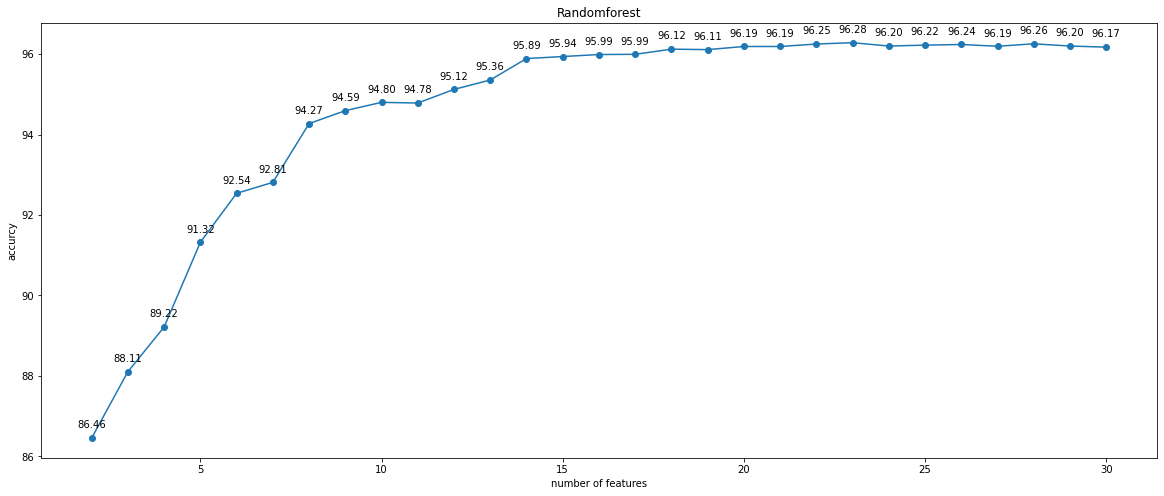

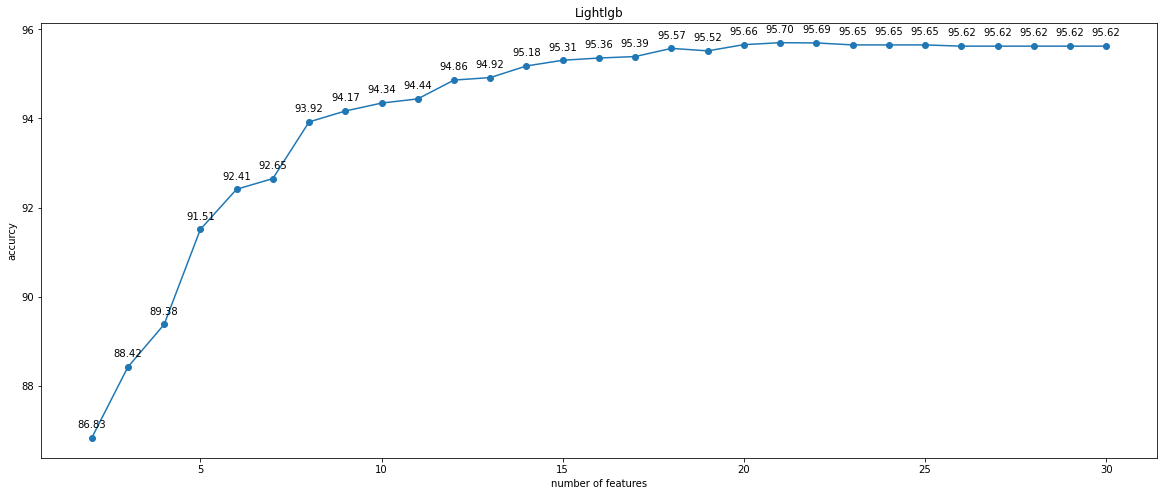

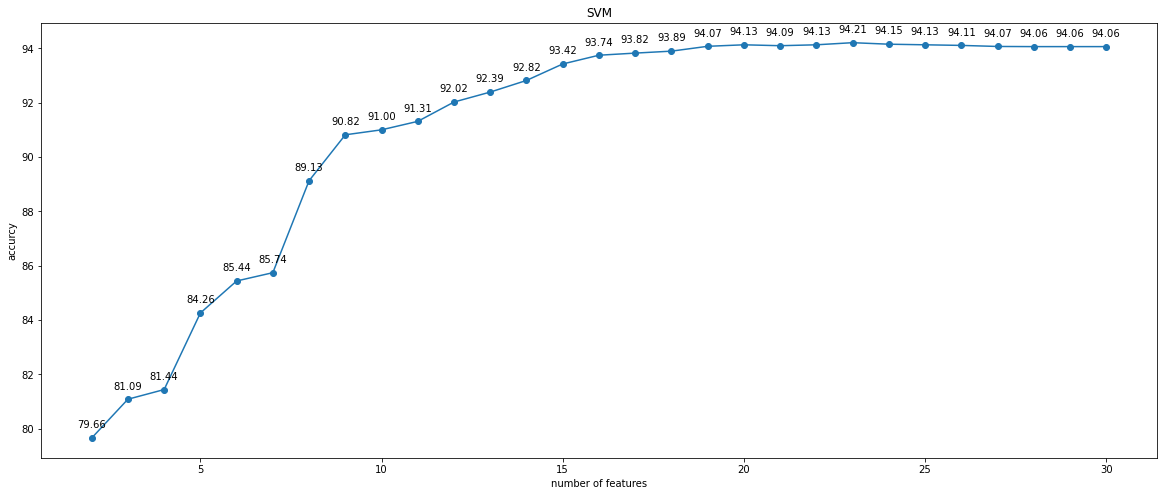

In [87]:
x = rfedata_result['numfeatures']
ylist = [rf_accuracy, lgb_accuracy, svm_accuracy]
graphname = ['Randomforest', 'Lightlgb', 'SVM']
for y,gname in zip(ylist,graphname):   
    plt.figure(figsize=(20, 8))
    plt.plot(x, y, marker='o')

    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.annotate(f'{yi:.2f}', (xi, yi), textcoords="offset points", 
                     xytext=(0, 10), ha='center')
    plt.title(gname)
    plt.xlabel('number of features')
    plt.ylabel('accurcy')
    plt.show()

## PSO

In [ ]:
%pip install niapy --pre

In [2]:
from niapy.problems import Problem
from niapy.task import Task
from niapy.algorithms.basic import ParticleSwarmOptimization

In [21]:
classifier = RandomForestClassifier(n_estimators=300)

In [23]:
data =[]
class FeatureSelection(Problem):
    def __init__(self, X_train, y_train, alpha=0.99):
        super().__init__(dimension=X_train.shape[1], lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.alpha = alpha
        
    def _evaluate(self, x):
        selected = x > 0.5
        num_selected = selected.sum()
        if num_selected == 0:
            return 1.0
        accuracy = cross_val_score(classifier, self.X_train.loc[:, selected], self.y_train, cv=2, n_jobs=-1).mean()
        score = 1 - accuracy
        num_features = self.X_train.shape[1]
        f = self.alpha * score + (1 - self.alpha) * (num_selected / num_features)
        data.append({'num_selected' : num_selected,
                     'column_selected' : (X_train.columns)[selected].tolist(),
                     'accuracy' : accuracy,
                     'cost' : f
        })
        return f

In [ ]:
problem = FeatureSelection(X, y)
task = Task(problem, max_iters=100)
algorithm = ParticleSwarmOptimization(population_size=10, seed=1234)
best_features, best_fitness = algorithm.run(task)
print(best_features)
print(best_fitness)

In [ ]:
selected_features = best_features > 0.5
print('Number of selected features:', selected_features.sum())
print('Selected features:', ', '.join((X_train.columns)[selected_features].tolist()))

In [ ]:
features_selected = (X_train_stand.columns)[selected_features].tolist()

In [ ]:
f_data = pd.DataFrame(data)
f_data[f_data['cost'] == f_data['cost'].min()]

In [73]:
features_selected_ver1 = [ 'domainlength', 'www', 'https', 'short_url', '@', '-', '=', '.', '/' ,'digit', 
                     'pcemptylinks', 'pcextlinks', 'pcrequrl','zerolink', 'sfh', 'redirection', 'domainend']

features_selected_ver2 = ['domainlength', 'www','http', 'https', 'short_url', '@', '-', '=', '.', '/' , 
                  'pcemptylinks', 'pcextlinks', 'pcrequrl','zerolink', 'redirection','domainage', 'domainend']

features_selected_ver3 = ['domainlength', 'www', 'https', 'short_url', 'ip','-', '=', '.', '/', '_', 'digit', 'pcemptylinks', 'pcextlinks', 'pcrequrl','zerolink',
                     'extfavicon', 'sfh', 'redirection', 'domainend']
features_selected = features_selected_ver3 

### version 1

In [88]:
features_selected = features_selected_ver1 

In [89]:
print("Number of selected features :", len(features_selected))
print("Feature Eliminated :", list(set(X.columns)- set(features_selected)))
print("Feature selected   :", features_selected)

Number of selected features : 17
Feature Eliminated : ['pay', 'http', 'cmd', '_', 'ip', 'extfavicon', 'log', 'subdomain', 'submit2email', 'web', 'domainage', 'account']
Feature selected   : ['domainlength', 'www', 'https', 'short_url', '@', '-', '=', '.', '/', 'digit', 'pcemptylinks', 'pcextlinks', 'pcrequrl', 'zerolink', 'sfh', 'redirection', 'domainend']


In [90]:
all_feature_models = model_allfeatures(models, X_train_stand[features_selected], y_train, X_test_stand[features_selected], y_test)
model_allfeatures_df = pd.DataFrame(all_feature_models)
model_allfeatures_df

[LightGBM] [Info] Number of positive: 24500, number of negative: 24500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,model,fit_time,feature_importances,accuracy score,classification_report,confusion_matrix
0,"(DecisionTreeClassifier(max_features='sqrt', r...",10.332729,"[0.1448759278958812, 0.08392338692750372, 0.06...",0.959714,"{'0': {'precision': 0.9588403041825095, 'recal...","[[10087, 413], [433, 10067]]"
1,LGBMClassifier(),0.198374,"[541, 59, 138, 41, 15, 102, 113, 169, 210, 218...",0.951667,"{'0': {'precision': 0.9487179487179487, 'recal...","[[10027, 473], [542, 9958]]"
2,SVC(),26.511514,None,0.942048,"{'0': {'precision': 0.9304460725215618, 'recal...","[[10033, 467], [750, 9750]]"


In [91]:
model_allfeatures_df.to_csv('pso_tts_ver1.csv',index=False)

In [92]:
kfoldrfecv_result = kfoldcv_allfeatures(models,X[features_selected],y)
kfoldrfecv_result_df = pd.DataFrame(kfoldrfecv_result)
kfoldrfecv_result_df

[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 984
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000

,model,fit_time,score_time,avg_accuracy,avg_precison,avg_recall,avg_f1
0,"(DecisionTreeClassifier(max_features='sqrt', r...",11.491538,0.468650,0.959943,0.961210,0.958571,0.959943
1,LGBMClassifier(),0.250172,0.036811,0.951857,0.954405,0.949057,0.951857
2,SVC(),27.335760,11.901387,0.940629,0.953037,0.926943,0.940617


In [93]:
kfoldrfecv_result_df.to_csv('pso_cv_ver1.csv',index=False)

### version 2

In [94]:
features_selected = features_selected_ver2

In [95]:
print("Number of selected features :", len(features_selected))
print("Feature Eliminated :", list(set(X.columns)- set(features_selected)))
print("Feature selected   :", features_selected)

Number of selected features : 17
Feature Eliminated : ['pay', 'cmd', 'sfh', '_', 'ip', 'extfavicon', 'account', 'log', 'subdomain', 'submit2email', 'web', 'digit']
Feature selected   : ['domainlength', 'www', 'http', 'https', 'short_url', '@', '-', '=', '.', '/', 'pcemptylinks', 'pcextlinks', 'pcrequrl', 'zerolink', 'redirection', 'domainage', 'domainend']


In [96]:
all_feature_models = model_allfeatures(models, X_train_stand[features_selected], y_train, X_test_stand[features_selected], y_test)
model_allfeatures_df = pd.DataFrame(all_feature_models)
model_allfeatures_df

[LightGBM] [Info] Number of positive: 24500, number of negative: 24500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,model,fit_time,feature_importances,accuracy score,classification_report,confusion_matrix
0,"(DecisionTreeClassifier(max_features='sqrt', r...",9.847514,"[0.15248214085282913, 0.08855961156837162, 0.0...",0.957476,"{'0': {'precision': 0.9559563360227812, 'recal...","[[10071, 429], [464, 10036]]"
1,LGBMClassifier(),0.197182,"[594, 73, 0, 133, 47, 18, 122, 132, 183, 234, ...",0.950810,"{'0': {'precision': 0.9458415748328153, 'recal...","[[10042, 458], [575, 9925]]"
2,SVC(),28.073855,None,0.936524,"{'0': {'precision': 0.9277648156789547, 'recal...","[[9941, 559], [774, 9726]]"


In [97]:
model_allfeatures_df.to_csv('pso_tts_ver2.csv',index=False)

In [98]:
kfoldrfecv_result = kfoldcv_allfeatures(models,X[features_selected],y)
kfoldrfecv_result_df = pd.DataFrame(kfoldrfecv_result)
kfoldrfecv_result_df

[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 949
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000

,model,fit_time,score_time,avg_accuracy,avg_precison,avg_recall,avg_f1
0,"(DecisionTreeClassifier(max_features='sqrt', r...",11.271084,0.475748,0.957014,0.958311,0.955600,0.957014
1,LGBMClassifier(),0.246838,0.038917,0.952329,0.956388,0.947886,0.952327
2,SVC(),27.110734,12.409705,0.935871,0.945159,0.925457,0.935864


In [99]:
kfoldrfecv_result_df.to_csv('pso_cv_ver2.csv',index=False)

### version 3

In [82]:
features_selected = features_selected_ver3 

In [83]:
print("Number of selected features :", len(features_selected))
print("Feature Eliminated :", list(set(X.columns)- set(features_selected)))
print("Feature selected   :", features_selected)

Number of selected features : 19
Feature Eliminated : ['pay', 'http', 'cmd', 'log', '@', 'subdomain', 'submit2email', 'web', 'domainage', 'account']
Feature selected   : ['domainlength', 'www', 'https', 'short_url', 'ip', '-', '=', '.', '/', '_', 'digit', 'pcemptylinks', 'pcextlinks', 'pcrequrl', 'zerolink', 'extfavicon', 'sfh', 'redirection', 'domainend']


In [84]:
all_feature_models = model_allfeatures(models, X_train_stand[features_selected], y_train, X_test_stand[features_selected], y_test)
model_allfeatures_df = pd.DataFrame(all_feature_models)
model_allfeatures_df

[LightGBM] [Info] Number of positive: 24500, number of negative: 24500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1001
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,model,fit_time,feature_importances,accuracy score,classification_report,confusion_matrix
0,"(DecisionTreeClassifier(max_features='sqrt', r...",10.094017,"[0.1286955965279878, 0.08360886795600325, 0.06...",0.961000,"{'0': {'precision': 0.9603423680456491, 'recal...","[[10098, 402], [417, 10083]]"
1,LGBMClassifier(),0.216979,"[493, 61, 128, 41, 0, 98, 109, 153, 222, 27, 2...",0.953095,"{'0': {'precision': 0.9501371936796291, 'recal...","[[10042, 458], [527, 9973]]"
2,SVC(),29.443032,None,0.943381,"{'0': {'precision': 0.9335133625104758, 'recal...","[[10025, 475], [714, 9786]]"


In [85]:
model_allfeatures_df.to_csv('pso_tts_ver3.csv',index=False)

In [86]:
# Train Model with Kfold
kfoldrfecv_result = kfoldcv_allfeatures(models,X[features_selected],y)
kfoldrfecv_result_df = pd.DataFrame(kfoldrfecv_result)
kfoldrfecv_result_df

[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1006
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1009
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

,model,fit_time,score_time,avg_accuracy,avg_precison,avg_recall,avg_f1
0,"(DecisionTreeClassifier(max_features='sqrt', r...",11.494605,0.484401,0.961300,0.962744,0.959743,0.961300
1,LGBMClassifier(),0.273197,0.038800,0.953114,0.956034,0.949914,0.953114
2,SVC(),29.728958,12.461402,0.941743,0.953172,0.929143,0.941733


In [87]:
kfoldrfecv_result_df.to_csv('pso_cv_ver3.csv',index=False)

## Embedded method : Rf feature Selection

In [55]:
from sklearn.feature_selection import SelectFromModel

In [56]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 300))
sel.fit(X_train_stand, y_train)
sel.get_support()

array([ True,  True, False,  True, False, False, False, False,  True,
       False, False, False,  True,  True, False, False, False, False,
       False,  True,  True,  True,  True, False, False, False,  True,
       False, False])

In [63]:
selected_feat= X_train_stand.columns[(sel.get_support())].tolist()
print(selected_feat)
len(selected_feat)

['domainlength', 'www', 'https', '-', '/', 'digit', 'pcemptylinks', 'pcextlinks', 'pcrequrl', 'zerolink', 'redirection']


11

In [72]:
print("Number of selected features :", len(selected_feat))
print("Feature Eliminated :", X.columns[(sel.get_support()) == False].tolist())
print("Feature selected   :", X.columns[(sel.get_support())].tolist())

Number of selected features : 11
Feature Eliminated : ['subdomain', 'http', 'short_url', 'ip', '@', '=', '.', '_', 'log', 'pay', 'web', 'cmd', 'account', 'extfavicon', 'submit2email', 'sfh', 'domainage', 'domainend']
Feature selected   : ['domainlength', 'www', 'https', '-', '/', 'digit', 'pcemptylinks', 'pcextlinks', 'pcrequrl', 'zerolink', 'redirection']


In [58]:
all_feature_models = model_allfeatures(models, X_train_stand[selected_feat], y_train, X_test_stand[selected_feat], y_test)
model_allfeatures_df = pd.DataFrame(all_feature_models)
model_allfeatures_df

[LightGBM] [Info] Number of positive: 24500, number of negative: 24500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,model,fit_time,feature_importances,accuracy score,classification_report,confusion_matrix
0,"(DecisionTreeClassifier(max_features='sqrt', r...",9.452961,"[0.1547653510528774, 0.09496654490081621, 0.06...",0.950524,"{'0': {'precision': 0.948856627763545, 'recall...","[[10000, 500], [539, 9961]]"
1,LGBMClassifier(),0.194000,"[646, 81, 130, 134, 266, 285, 443, 563, 202, 1...",0.945095,"{'0': {'precision': 0.9404391669022713, 'recal...","[[9979, 521], [632, 9868]]"
2,SVC(),21.491013,None,0.927714,"{'0': {'precision': 0.9215318190351042, 'recal...","[[9818, 682], [836, 9664]]"


In [60]:
model_allfeatures_df.to_csv('emrf_tts.csv',index=False)

In [59]:
# Train Model with Kfold
kfoldrfecv_result = kfoldcv_allfeatures(models,X[selected_feat],y)
kfoldrfecv_result_df = pd.DataFrame(kfoldrfecv_result)
kfoldrfecv_result_df

[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 28000, number of negative: 28000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000

,model,fit_time,score_time,avg_accuracy,avg_precison,avg_recall,avg_f1
0,"(DecisionTreeClassifier(max_features='sqrt', r...",10.377399,0.425403,0.951257,0.950872,0.951686,0.951257
1,LGBMClassifier(),0.222997,0.032998,0.945829,0.948271,0.943114,0.945828
2,SVC(),24.285413,12.963796,0.925471,0.931242,0.918800,0.925467


In [61]:
kfoldrfecv_result_df.to_csv('emrf_cv.csv',index=False)